<a href="https://colab.research.google.com/github/blawok/color-generator/blob/master/color_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 3.0MB 15.3MB/s 
     |████████████████████████████████| 890kB 29.5MB/s 
     |████████████████████████████████| 1.1MB 31.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=d4b3f3e6d69269318bbf7a88b33814379dd08a1b48837ba362e7ca23c2aa221a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.backend as K

from transformers import *
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

def norm(value):
    return value / 255.0

def scale(n):
    return int(n * 255)

In [4]:
df = pd.read_csv('colors.csv')

In [5]:
df.sample(5)

,name,red,green,blue
11670,rock gray,128,132,135
10924,shagreen,201,205,156
1688,soft moonlight,239,236,216
10003,smokestack gray,115,131,136
6069,sweet curry,232,167,116


In [6]:
df.shape

(14157, 4)

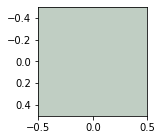

In [12]:
plot_rgb([192, 206, 195])

## Preprocessing

In [7]:
def _convert_to_distilbert_inputs(text, tokenizer, max_sequence_length):
    
    def return_id(str1, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1,
            add_special_tokens=True,
            max_length=length,
            truncation_strategy=truncation_strategy,
            truncation=True
            )
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        
        return [input_ids, input_masks]
    
    input_ids, input_masks = return_id(
        text,
        'longest_first',
        max_sequence_length)

    return [input_ids, input_masks]

def compute_input_arrays_distilbert(df, columns, tokenizer, max_sequence_length):
    input_ids, input_masks = [], []

    for i in df[columns]:
        ids, masks = _convert_to_distilbert_inputs(i, tokenizer, max_sequence_length)
        
        input_ids.append(ids)
        input_masks.append(masks)
        
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32)]

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

MAX_SEQUENCE_LENGTH = 32

In [9]:
inputs = compute_input_arrays_distilbert(df,
                                         'name', 
                                         tokenizer,
                                         MAX_SEQUENCE_LENGTH)

In [10]:
y = np.column_stack([norm(df["red"]), norm(df["green"]), norm(df["blue"])])

## Model

In [11]:
def create_distilbert_model(freeze = True):
    qa = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    qa_mask = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    config = DistilBertConfig()
    config.output_hidden_states = False
    transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased',
                                                        config=config)

    for layer in transformer_model.layers:
        layer.trainable = False

    qa_embedding = transformer_model(qa, attention_mask=qa_mask)[0]
    cls_encodings = tf.squeeze(qa_embedding[:, 0:1, :], axis=1)
    output_dense = Dense(3, activation='sigmoid')(cls_encodings)

    model = Model(inputs=[qa, qa_mask], outputs=output_dense)
    return model

In [38]:
K.clear_session()
distilbert_base = create_distilbert_model(freeze=True)
optimizer = Adam(learning_rate=3e-4)
distilbert_base.compile(loss='mse', optimizer=optimizer)
distilbert_base.summary()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 32, 768),)   66362880    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 1, 768)]     0           tf_distil_bert_model[0

In [39]:
distilbert_base.fit(inputs,
                    y,
                    epochs=5,
                    batch_size=64)

Epoch 1/5
222/222 [==============================] - 33s 147ms/step - loss: 0.0685
Epoch 2/5
222/222 [==============================] - 34s 153ms/step - loss: 0.0617
Epoch 3/5
222/222 [==============================] - 34s 155ms/step - loss: 0.0587
Epoch 4/5
222/222 [==============================] - 32s 142ms/step - loss: 0.0567
Epoch 5/5
222/222 [==============================] - 34s 153ms/step - loss: 0.0552


In [14]:
def predict_color(input_text):
    input_ids, input_masks = [], []
    ids, masks = _convert_to_distilbert_inputs(input_text, tokenizer, 32)
    input_ids.append(ids)
    input_masks.append(masks)
    model_input = [[np.asarray(input_ids, dtype=np.int32),
                   np.asarray(input_masks, dtype=np.int32)]]
    return distilbert_base.predict(model_input)

[[0.46994004 0.593255   0.40254632]]


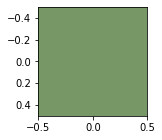

In [50]:
color = predict_color('green')
print(color)
plot_rgb([scale(c) for c in color[0]])

[[0.77720666 0.6112091  0.5919229 ]]


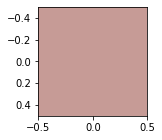

In [51]:
color = predict_color('pink')
print(color)
plot_rgb([scale(c) for c in color[0]])

[[0.5130302 0.6887945 0.7163092]]


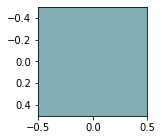

In [52]:
color = predict_color('ocean')
print(color)
plot_rgb([scale(c) for c in color[0]])